In [78]:
import torch
from torch import nn
import torch.nn.functional as F
import math
import matplotlib.pyplot as plt

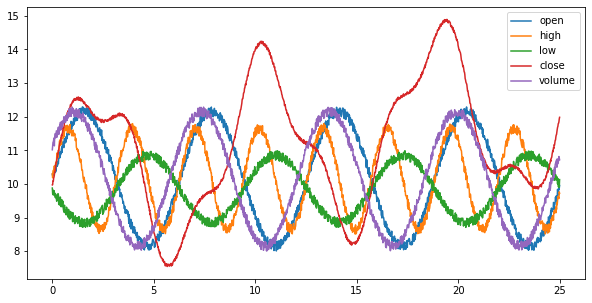

In [79]:
t = torch.linspace(0, 25, 1500)
open = 10 + 2 * torch.sin(t) + 0.3 * torch.rand(t.shape)
high = 10 + 1.5 * torch.sin(2 * t) + 0.3 * torch.rand(t.shape)
low = 10 + torch.sin(-t) - 0.3 * torch.rand(t.shape)
close = 10 + 2.5 * torch.sin(0.75 * t) + 0.75 * torch.sin(2 * t) + 0.1 * t - 0.1 * torch.rand(t.shape)
volume = 10 + 2 * torch.sin(t + 0.5) + 0.3 * torch.rand(t.shape)

plt.figure(figsize=(10, 5))
plt.plot(t, open, label='open')
plt.plot(t, high, label='high')
plt.plot(t, low, label='low')
plt.plot(t, close, label='close')
plt.plot(t, volume, label='volume')
plt.legend();
# will be attempting to predict the change in close price

In [80]:
X = torch.stack([open, high, low, close, volume], dim=1)
X.shape

torch.Size([1500, 5])

In [81]:
y = torch.tensor([(b - a) / a for a, b in zip(close[:-1], close[1:])])
y.shape

torch.Size([1499])

In [82]:
# need to drop the very first value of X and t
X = X[1:]
t = t[1:]

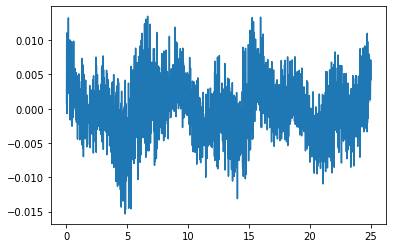

In [83]:
plt.plot(t, y);

In [84]:
train_split = int(0.8 * len(X))
test_split = int(0.9 * len(X))

X_train, X_test, X_val = X[:train_split], X[train_split:test_split], X[test_split:]
y_train, y_test, y_val = y[:train_split], y[train_split:test_split], y[test_split:]

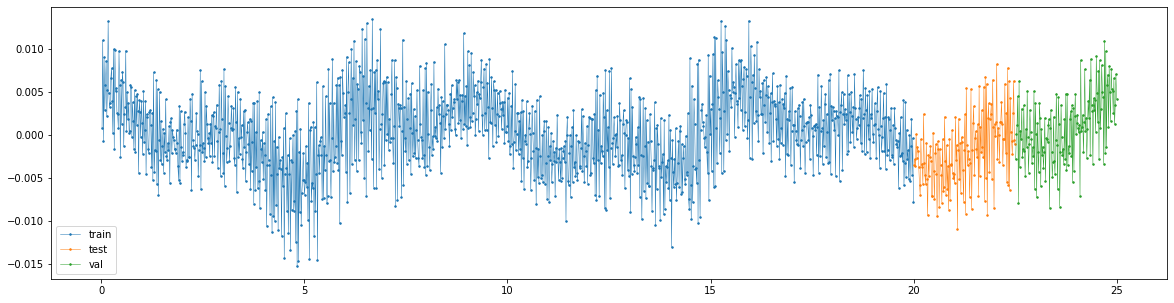

In [128]:
plt.figure(figsize=(20, 5))
plt.plot(t[:train_split], y_train, label='train', linewidth=0.5, marker='.', markersize=3)
plt.plot(t[train_split:test_split], y_test, label='test', linewidth=0.5, marker='.', markersize=3)
plt.plot(t[test_split:], y_val, label='val', linewidth=0.5, marker='.', markersize=3)
plt.legend();
# here are our splits and what we are trying to predict

In [86]:
# this is just a toy model and the only thing that affects the target is the close price
# the hope being that the model will realise this and learn to predict the change in close price

In [98]:
## Model parameters
dim_val = 512 # This can be any value divisible by n_heads. 512 is used in the original transformer paper.
n_heads = 8 # The number of attention heads (aka parallel attention layers). dim_val must be divisible by this number
n_decoder_layers = 4 # Number of times the decoder layer is stacked in the decoder
n_encoder_layers = 4 # Number of times the encoder layer is stacked in the encoder
input_size = 5 # The number of input variables. 1 if univariate forecasting.
num_predicted_features = 1 # The number of output variables.
dec_seq_len = 92 # length of input given to decoder. Can have any integer value.
enc_seq_len = 128 # length of input given to encoder. Can have any integer value.
output_sequence_length = 3 # Length of the target sequence, i.e. how many time steps should your forecast cover
max_seq_len = enc_seq_len # What's the longest sequence the model will encounter? Used to make the positional encoder

In [93]:
# input_shape = (32, 128, 5) - batch_size, sequence_length, features

In [94]:
# we begin by teaching the model what time means
# this will be doen with a time embedding layer following the Time2Vec paper

class Time2Vec(nn.Module):
    def __init__(self, seq_len):
        super().__init__()
        self.seq_len = seq_len
        self.linear_time = nn.Linear(seq_len, seq_len)
        self.periodic_time = nn.Linear(seq_len, seq_len)

    def forward(self, x):
        x = x[:, :, 3].view(-1, self.seq_len) # use only the close price for this one
        linear_time = self.linear_time(x).view(-1, self.seq_len, 1)        
        periodic_time = torch.sin(self.periodic_time(x)).view(-1, self.seq_len, 1)
        return torch.cat([linear_time, periodic_time], dim=-1)     

In [95]:
test_batch = torch.rand(32, 128, 5)
m = Time2Vec(128)
m(test_batch).shape

torch.Size([32, 128, 2])

In [113]:
# alternatively we could use a positional encoding layer like in the original transformer paper

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000, batch_first=False):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        self.batch_first = batch_first
        self.x_dim = 1 if batch_first else 0

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)

        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

        

    def forward(self, x):
        print(self.pe[:x.size(self.x_dim)].shape)
        x = x + self.pe[:x.size(self.x_dim)]
        return self.dropout(x)

In [115]:
test_batch = torch.rand(32, 128, 5)
encoder_input_layer = nn.Linear(5, dim_val) # linear layer before positional encoding
test_batch = encoder_input_layer(test_batch)
print(test_batch.shape)
m = PositionalEncoding(dim_val, max_len=max_seq_len)
m(test_batch).shape

torch.Size([32, 128, 512])
torch.Size([32, 1, 512])


torch.Size([32, 128, 512])

In [133]:
class TimeSeriesTransformer(nn.Module):
    def __init__(
        self,
        input_size,
        dec_seq_len,
        batch_first=True,
        out_seq_len=58,
        max_seq_len=128,
        dim_val=512,
        n_encoder_layers=4,
        n_decoder_layers=4,
        n_heads=8,
        dropout_encoder=0.2,
        dropout_decoder=0.2,
        dropout_pos_enc=0.1,
        dim_feedforward_enc=2048,
        dim_feedforward_dec=2048,
        num_predicted_feats=1,
    ):
        super().__init__()
        self.dec_seq_len = dec_seq_len

        self.encoder_input_layer = nn.Linear(input_size, dim_val)

        self.decoder_input_layer = nn.Linear(num_predicted_feats, dim_val)

        self.linear_mapping = nn.Linear(dim_val, num_predicted_feats)

        self.positional_enc_layer = PositionalEncoding(dim_val, dropout=dropout_pos_enc, max_len=max_seq_len)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=dim_val,
            nhead=n_heads,
            dim_feedforward=dim_feedforward_enc,
            dropout=dropout_encoder,
        )

        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=n_encoder_layers)

        decoder_layer = nn.TransformerDecoderLayer(
            d_model=dim_val,
            nhead=n_heads,
            dim_feedforward=dim_feedforward_dec,
            dropout=dropout_decoder,
            batch_first=batch_first
        )

        self.decoder = nn.TransformerDecoder(
            decoder_layer=decoder_layer,
            num_layers=n_decoder_layers, 
            norm=None
        )

    def forward(self, src, tgt, src_mask, tgt_mask):
        src = self.encoder_input_layer(src)
        src = self.positional_encoding_layer(src)
        src = self.encoder(src)

        decoder_output = self.decoder_input_layer(tgt)
        decoder_output = self.decoder(
            tgt=decoder_output,
            memory=src,
            tgt_mask=tgt_mask,
            memory_mask=src_mask
        )

        decoder_output = self.linear_mapping(decoder_output)

        return decoder_output

In [135]:
model = TimeSeriesTransformer(
    dim_val=dim_val,
    input_size=input_size, 
    dec_seq_len=dec_seq_len,
    max_seq_len=max_seq_len,
    out_seq_len=output_sequence_length, 
    n_decoder_layers=n_decoder_layers,
    n_encoder_layers=n_encoder_layers,
    n_heads=n_heads
)